# Star Type Classification

Classifying the star type of an unclassifed star using its absolute temperature and absolute magnitude

# Part I: Introduction

There are many different types of stars that exist in our universe, and they can be classified into different categories. Grouping stars of similar characteristics allows individuals from astronomers to the general public to glean the general characteristics of a star, such as age, magnitude, or origin, simply by knowing its "star type." For our project we will consider two specific characteristics of stars, use them to classify the star type of an unclassified star, and determine how accurately these two characteristics can be used to predict star type. A high accuracy would indicate that these characteristics have unique ranges corresponding to different star types, thus they can be used as indications of star type.

To obtain data on stars, we will be using the “Star dataset to predict star types” dataset from Kaggle, which consists of data for 240 observations (240 stars). The characteristics, or variables, recorded are indicated along with the units of measurement as follows:
- Absolute Temperature (Kelvin)
- Relative Luminosity (L/Lo)
- Relative Radius (R/Ro)
- Absolute Magnitude (Mv)
    {note: Mv= m - 2.5log[(d/10)^2]}
- Star color (white, red, blue, etc.)
- Spectral class (O, B, A etc.)

The 6 different star types considered in this data set are given a generic numerical value for ease of use in classification and are as follows:
- Brown Dwarf (star type = 0)
- Red Dwarf (star type = 1)
- White Dwarf (star type = 2)
- Main sequence (star type = 3)
- Supergiant (star type = 4)
- Hypergiant (star type = 5)

For the purpose of our classification, we will only be using **Absolute Temperature (K)** and **Absolute Magnitude (Mv)** to predict the **Star Type** of an unclassified star, guided by the question: “can we create a classifier that can accurately classify the Star Type of an unclassified star?” All other variables will be removed from the data set before we begin our classification.

# Part II: Preliminary exploratory data analysis

- Demonstrate that the dataset can be read from the web into R 
- Clean and wrangle your data into a tidy format
- **Using only training data**, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 
- **Using only training data**, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.


In [20]:
# delete above cell once done

To begin, we created a Jupyter Notebook and attached all of the packages that we would need for our classification. We also set a random seed so we would not risk forgetting it later.

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
install.packages("kknn")
library(kknn)

set.seed(777)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

Next, we loaded the dataset from Kaggle into our notebook. The original column names had spaces, so we changed the names into a more usable format. Additionally, the star type column was of the wrong data type so we converted it into data type "factor". Finally, we selected only the columns that we are interested in for our classification (absolute temperature, absolute magnitude, and star type). The data is now in a tidy format and ready for use in classifcation.

To give a sense of how the data looks now, we have shown the first 6 and last 6 rows.
    
{note: the dataset has 240 observations, so there are 240 rows. Additionally, the data is currently organised in order of increasing star type (0-6).}

In [2]:
raw_data <- read_csv("https://raw.githubusercontent.com/uchou92/dcsi-100-2023w1-group-28/main/6_class_csv%5B1%5D.csv", col_names=FALSE,
             skip=1)

colnames(raw_data) <- c("abs_temperature", "luminosity", "radius", "abs_magnitude", "star_type", "star_color", "spectral_class")

star_data <- raw_data|>
        mutate(star_type = as_factor(star_type))|>
        mutate(star_type = fct_recode(star_type, "star_type" = "star_type"))|>
        select(abs_magnitude, star_type, abs_temperature)

head(star_data) 
tail(star_data)

Rows: 240 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): X6, X7
dbl (5): X1, X2, X3, X4, X5

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `star_type = fct_recode(star_type, star_type = "star_type")`.
Caused by warning:
! Unknown levels in `f`: star_type”


abs_magnitude,star_type,abs_temperature
<dbl>,<fct>,<dbl>
16.12,0,3068
16.60,0,3042
18.70,0,2600
16.65,0,2800
20.06,0,1939
16.98,0,2840


abs_magnitude,star_type,abs_temperature
<dbl>,<fct>,<dbl>
-7.67,5,21904
-9.93,5,38940
-10.63,5,30839
-10.73,5,8829
-11.23,5,9235
-7.80,5,37882


The first step to beginning our classification is to separate our data into a training set and a testing set. We used a 75% training-testing split, and stratified by star type so as to avoid class imbalance in either the testing or training data sets.

In [3]:
data_split <- star_data |>
            initial_split(prop = 0.75, strata = star_type)

data_training <- training(data_split)
data_testing <- testing(data_split)

To give an overview of what our training set looks like now that it is ready for use in classification, we have summarised how many of each star type is present in the training set. Since we know there were 240 original observations, we should have 75% so 30 observations of each star type in our training set. If we don't, then we know we have some missing data.

{note: there is no missing data!}

In [4]:
summary_training <- data_training |>
                    group_by(star_type) |>
                    summarize(count = n()) |>
                    arrange(desc(count))
summary_training

star_type,count
<fct>,<int>
0,30
1,30
2,30
3,30
4,30
5,30


As well, we are also providing a visualisation of the relationship between absolute temperature, absolute magnitude, and star type. Already it is possible to see that the different star types are grouped in different regions on the plot, indicating that we should have some success with our classifier.

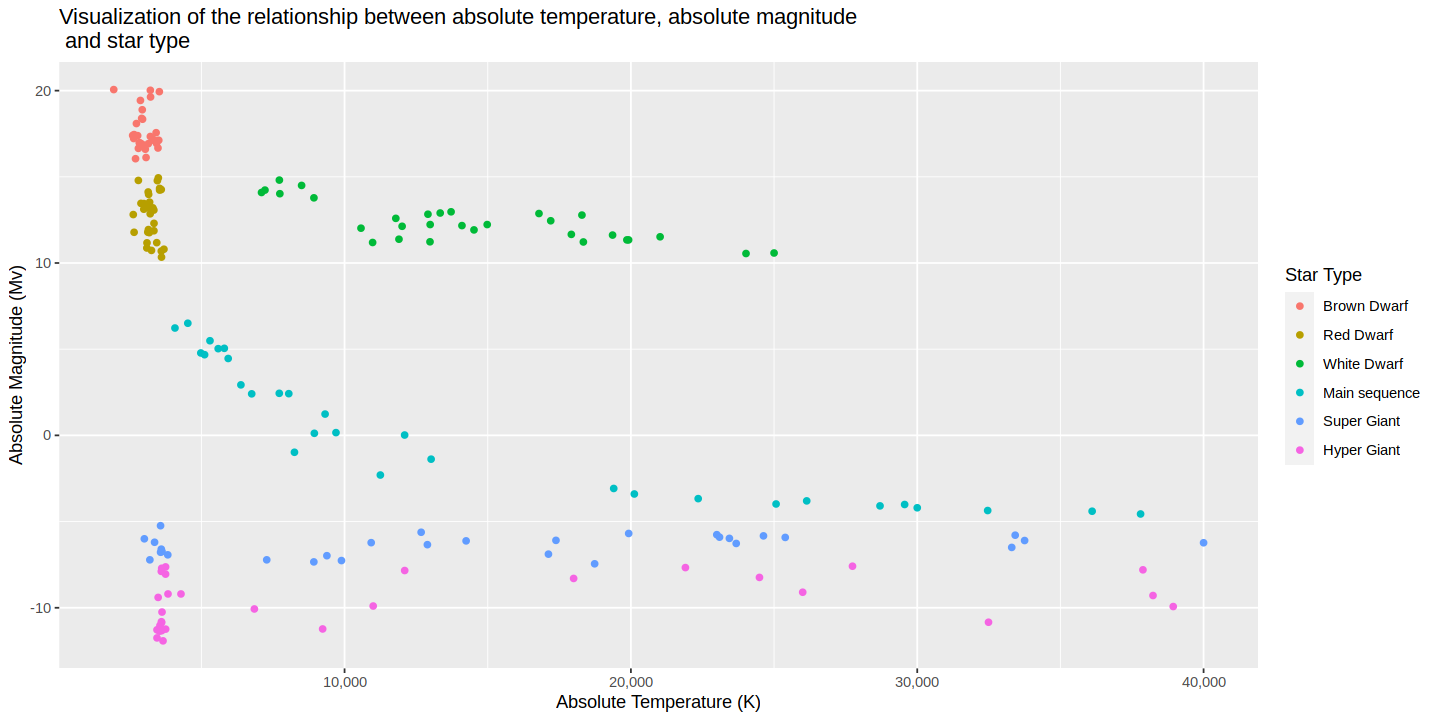

In [21]:
summary_plot_training <- data_training|>
    ggplot(aes(x = abs_temperature, y = abs_magnitude, color = star_type))+
            geom_point()+
            scale_color_hue(labels = c("Brown Dwarf", "Red Dwarf", "White Dwarf","Main sequence", "Super Giant", "Hyper Giant")) +
            labs(x = "Absolute Temperature (K)", y = "Absolute Magnitude (Mv)", color = "Star Type") +
            ggtitle("Visualization of the relationship between absolute temperature, absolute magnitude \n and star type") +
            scale_x_continuous(labels = scales::comma_format())    
summary_plot_training

# Part III: Classification

#*move the coding stuff here*

We will be performing classification with K-nearest in order to classify Star Type using Absolute Temperature and Absolute Magnitude. We will first tune for K. 

# Part IV: Discussion

#*so this is just significance, etc.*

- We are expecting to successfully find the star type (6 classes ranging from 0-5) based on Temperature (K) and Absolute Magnitude(Mv) of a single unclassified point. 

- These findings could impact users who are not familiar with stars to easily identify those star types based on these characteristics. 

- Some future questions that this could lead to are what other variables can impact the classification of star types apart from absolute temperature and magnitude? Are there any exceptions to the identification of Star types that can occur due to these other variables? How can classification help us in the Astronomy in the real-world workplace such as NASA?


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.9500000,5,0.01619709,Preprocessor1_Model1
2,accuracy,multiclass,0.9500000,5,0.01619709,Preprocessor1_Model2
3,accuracy,multiclass,0.9277778,5,0.01416394,Preprocessor1_Model3
4,accuracy,multiclass,0.9111111,5,0.02222222,Preprocessor1_Model4
5,accuracy,multiclass,0.8666667,5,0.01039349,Preprocessor1_Model5


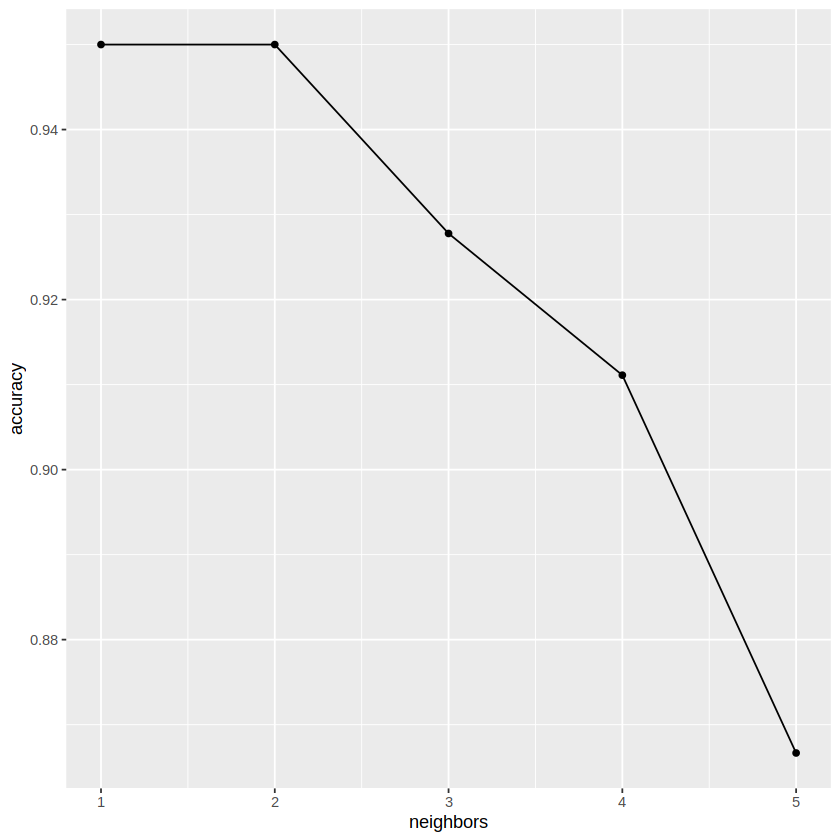

In [6]:
star_recipe <- recipe(star_type ~., data_training) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())

star_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")

star_vfold <- vfold_cv(data_training, v = 5, strata = star_type)

star_workflow <- workflow() |>
                    add_recipe(star_recipe) |>
                    add_model(star_spec)

gridvals <- tibble(neighbors = seq(from = 1, to = 5))

star_results <- star_workflow |> 
                    tune_grid(resamples = star_vfold, grid = gridvals) |>
                    collect_metrics() |>
                    filter(.metric == "accuracy")
star_results

star_plot <- star_results |> 
                ggplot(aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(x = "neighbors", y = "accuracy")
star_plot

In [7]:
star_main_spec <- nearest_neighbor(weight_func= "rectangular", n = 2 ) |>
                set_engine("kknn") |> 
                set_mode("classification")

star_fit <- workflow() |>
            add_recipe(star_recipe) |> 
            add_model(star_main_spec) |>
            fit(data_training)

In [8]:
star_predictions <- star_fit |>
                     predict(data_testing) |>
                     bind_cols(data_testing)
star_predictions

.pred_class,abs_magnitude,star_type,abs_temperature
<fct>,<dbl>,<fct>,<dbl>
0,18.700,0,2600
1,10.480,1,3628
2,11.890,2,16500
2,14.200,2,8570
2,14.470,2,7700
2,14.080,2,7230
3,-4.700,3,39000
3,-1.970,3,15276
4,-6.020,4,3270


In [9]:
star_metrics <- star_predictions |>
                metrics(truth = star_type, estimate = .pred_class) |>
                filter(.metric == "accuracy")
star_metrics


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.95


In [12]:
polaris <- tibble(abs_magnitude= -3.64, abs_temperature= 7200)
polaris

abs_magnitude,abs_temperature
<dbl>,<dbl>
-3.64,7200


In [13]:
polaris_prediction <-predict(star_fit, polaris)
polaris_prediction

.pred_class
<fct>
3


# Part V: References